# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей. 

## Задание

1. Выберите набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью трех подходящих для задачи метрик.
5. Постройте модель и оцените качество модели с использованием кросс-валидации. Проведите эксперименты с тремя различными стратегиями кросс-валидации.
6. Произведите подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации.
7. Повторите пункт 4 для найденного оптимального значения гиперпараметра K. Сравните качество полученной модели с качеством модели, полученной в пункте 4.
8. Постройте кривые обучения и валидации.

In [41]:
import pandas as pd
from enum import Enum
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np

In [42]:
data = pd.read_csv("train.csv",sep=",",encoding = 'cp1251')

In [43]:
data.head()

,id,bulk_id,spalen,date1,start_square,value,price,mean_sq,mean_fl,plan_s,...,До промки(км),До парка(км),До парка пешком(км),Станций метро от кольца,Площадь двора,Курс,Cтавка по ипотеке,Вклады до 1 года,Вклады от 1 года до 3 лет,Вклады свыше 3 лет
0,0,FF3814A9-9F7D-E711-8530-00505688958B,1,2017-10-01,13109.9,1124.5,135633.913043,38.00,8,147,...,0.28,0.58,0.93,8,7640,57.698052,10.04,5.74,5.94,6.03
1,1,FF3814A9-9F7D-E711-8530-00505688958B,2,2017-10-01,19898.4,1412.3,128492.419825,58.01,9,139,...,0.28,0.58,0.93,8,7640,57.698052,10.04,5.74,5.94,6.03
2,2,FF3814A9-9F7D-E711-8530-00505688958B,0,2017-10-01,2100.0,345.0,158237.634409,22.58,10,78,...,0.28,0.58,0.93,8,7640,57.698052,10.04,5.74,5.94,6.03
3,3,FF3814A9-9F7D-E711-8530-00505688958B,3,2017-10-01,9614.9,769.4,123250.000000,78.81,8,50,...,0.28,0.58,0.93,8,7640,57.698052,10.04,5.74,5.94,6.03
4,4,FF3814A9-9F7D-E711-8530-00505688958B,1,2017-11-01,11947.2,526.7,139420.634921,37.93,9,140,...,0.28,0.58,0.93,8,7640,58.926552,9.87,5.17,7.07,6.20


###  Проверим наличие пропущенных значениений

In [44]:
data.isnull().sum()

id                                       0
bulk_id                                  0
spalen                                   0
date1                                    0
start_square                             0
value                                    0
price                                    0
mean_sq                                  0
mean_fl                                  0
plan_s                                   0
plan_m                                   0
plan_l                                   0
vid_0                                    0
vid_1                                    0
vid_2                                    0
month                                    0
month_cnt                                0
Класс объекта                            0
Количество помещений                     0
Огорожена территория                     0
Площадь земельного участка               0
Входные группы                           0
Детский сад                              0
Школа      

Как мы видим пропущенных значений нет 

### Проверим наличие категориальных значений

In [45]:
cats = [col for col in data.columns if data[col].dtype=="object"]
print(len(cats))

12


Имеем 12 столбцов с категориальными признаками

### Заменим категориальные признаки числовыми используя Label encoding

In [46]:
le = LabelEncoder()
for col in cats:
    data[col]=le.fit_transform(data[col])

In [47]:
newcats = [col for col in data.columns if data[col].dtype=="object"]
print(len(newcats))

0


Так как наш целевой признак предназначен для регрессии - превратим его в признак для классификации

In [48]:
def regr_to_class(x):
    y=x["price"]
    if float(y)<150000:
        result = 'A'
    elif float(y)<200000:
        result = 'B'
    else:
        result = 'C'        
    return result 

In [49]:
y=data["price"]

In [50]:
for i in y:
    print(i,end="")

135633.913043128492.419825158237.634409123250.0139420.634921132136.99059600002163102.631579130635.087719145131.649832136454.915254167735.616438132329.52380999998144998.473282136632.733813167385.483871132593.0158492.105263176049.333333187111.47541171666.666667164138.020833151322.916667202708.333333160021.875179718.181818190520.512821171714.285714164461.309524153825.0218357.14285700003160686.538462179861.11111099995192535.135135171676.47058800005164560.897436153875.0218642.857143162368.75180314.814815194783.870968174900.0164218.253968155742.424242218583.333333162960.869565184020.833333196259.259259174882.35294100002163808.035714155566.666667218545.454545167000.0186305.555556200950.0179062.5167797.413793159066.666667223000.0168685.714286188884.615385205642.857143178900.0167808.035714159206.896552222944.444444171816.666667192750.0207625.0181272.727273169906.862745161220.0227375.0173020.0191687.5199166.666667183681.818182168835.106383162681.818182230285.714286173052.631579190416.66666720700

88004.833333388609.8571428999986182.078952.087155.082338.583000.084293.085009.588235386531.363636473998.085262.088076.7058823999886759.870989.085952.087656.777777885463.090909191239.666666786953.333333381581.078916.097000.094166.666666798600.094654.857142989210.096880.098700.099600.095047.089810.0102100.096300.0106800.090400.092516.666666799500.0102000.082100.094800.086648.4848485102731.2591142.105263297514.173228388258.563432875525.088113.131313193350.087600.082272.727272795242.458100688745.918367390433.333333392300.097500.0102000.094800.086621.875102697.8723491435.714285797910.875331689441.4143426000275526.315789589905.172413882750.095252.121212189160.9195401999890320.097500.094800.086621.875102673.33333391466.666666797930.376344189452.590361475527.777777890150.632911482750.094625.490196189225.090200.094800.086621.875102617.07317191330.097925.13661289603.326359875527.777777890314.173228380377.358490694599.319727988926.923076991434.482758696951.639344394456.923076982744.59459460001895

122231.428571107754.901961168800.0127284.0123435.59322122091.666667108131.578947119655.17241400002120027.027027109795.0163200.0106334.782609116600.0118800.0165855.555556119600.0131700.0130666.666667161700.0166250.0153533.333333125700.0140550.0180200.0154365.217391118062.5116878.26087149354.54545499998147500.0177100.0122272.222222107725.641026170575.0126715.384615123754.716981125142.857143108005.555556120197.826087119010.344828109795.0163250.0106290.909091116487.5119045.070423165950.0137460.0141166.666667174700.0179600.0179900.0130233.333333156000.0129500.0165162.5181200.0120350.0119218.181818156400.0150775.0122378.787879108092.105263170650.0136925.0123719.230769121775.0108206.25120278.571429119106.521739109795.0106290.909091116110.204082119545.0163000.0138300.0141166.666667174700.0124131.707317114022.222222159258.823529109371.428571173000.0125700.0182200.0142300.0166687.5119300.0118675.0165300.0155533.333333123035.714286108266.666667138175.0177300.0131014.285714108090.909091124797.5609

202057.142857144700.0164717.04545499998136285.714286198017.391304144809.677419155562.962963154366.666667174812.0221400.0141850.0157422.222222151045.45454500002194300.0158896.511628151710.714286141522.727273138654.166667185000.0153651.086957145285.507246135204.347826136879.166667178458.333333152509.090909175534.482759211440.0154050.0166290.697674198072.727273136840.0144170.833333154990.0174247.826087154900.0221400.0139500.0157773.684211151055.555556194300.0143347.368421153582.978723160800.0185472.222222139285.714286178852.173913146119.354839135742.857143154322.619048137438.095238151908.695652175836.0212233.333333153620.0164231.176471198250.0143390.0134300.0155747.058824174247.826087154900.0221400.0157773.684211151055.555556194300.0146405.555556155948.88888900002186855.555556161507.042254141223.809524178852.173913146587.096774135825.0154691.566265137438.095238153345.45454500002175595.74468099998212100.0152600.0137150.0163622.87581700002198033.333333145935.29411800002174064.0154616.666667

145333.333333180000.0140881.818182157343.75150254.54545499998180100.0139512.5146465.306122162000.0144470.588235148218.181818148770.833333174220.0141590.0147851.06383163228.571429188700.0130431.818182130906.060606142900.0197000.0140385.714286158308.333333150077.777778180100.0139512.5147311.363636162000.0144077.777778148218.181818148672.727273174360.0153744.444444159725.714286179066.666667131695.0131827.272727201000.0144500.0141918.181818158283.333333151114.285714136322.222222150866.666667142746.80851099998149990.909091145566.666667149291.666667175900.0171039.473684167300.0209807.407407160218.75184205.555556159887.096774170700.0179651.11111099995169716.666667163694.117647169050.61728399998169504.938272180222.580645209807.407407160386.666667173554.83870999998182875.675676162377.777778163475.0171078.378378168190.322581209807.407407160218.75184205.555556159413.793103170700.0170014.457831181250.0163375.0168944.736842172105.797101180975.0215050.0162386.666667174163.793103183867.647059162950.0

In [51]:
y=data.apply(lambda x:regr_to_class(x),axis=1)

In [52]:
y.unique()

array(['A', 'B', 'C'], dtype=object)

In [53]:
x=data.drop("price",axis=1)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [55]:
# Размер тренировочной выборки
print(X_train.shape, y_train.shape)
# Размер тестовой выборки
print(X_test.shape, y_test.shape)

(6980, 55) (6980,)
(1746, 55) (1746,)


### Обучим модель используя метод k близжайших значений

In [56]:
class PredictionType(Enum):
    CLASSIFICATION = 1
    REGRESSION = 2

In [57]:
class SimpleKNN:
    
    def fit(self, X_train: np.matrix, y_train: np.ndarray):
        self._X_train = X_train
        self._y_train = y_train
    
    def eucl_dist(self, p: np.ndarray, q: np.ndarray) -> float:
        return sum([(pi - qi) ** 2 for pi, qi in zip (p, q)])
    
    def predict_for_single_object(self, K: int, prediction_type: PredictionType,\
                                  X_o: np.ndarray, verbose = True) -> np.ndarray:
        """
        Метод предсказания для одного объекта.
        Входные параметры:
        K - гиперпараметр, количество соседей 
        prediction_type - классификация или регрессия 
        X_o - строка матрицы объект-признак, соответствующая объекту
        verbose - флаг детального вывода
        Возвращаемое значение: предсказанное значение целевого признака
        """
        # список соседей
        neighbors_list = []
        # *** Находим ближайшие точки ***
        # Перебираем все точки обучающей выборки
        for i in range(self._X_train.shape[0]):
            # получаем текущую точку
            data_train_current_x = [x for x in self._X_train.iloc[i]]
            # и значение ее y
            data_train_current_y = self._y_train[i]
            # вычисляем расстояние
            dist = self.eucl_dist(X_o, data_train_current_x)
            # сохраняем в список соседей
            temp_res = (data_train_current_y, dist, data_train_current_x)
            neighbors_list.append(temp_res)
        # *** сортируем список соседей по возрастанию расстояния *** 
        # в кортеже элементы следуют в порядке (0,1,2), сортируем по первому элементу 
        neighbors_list_sorted = sorted(neighbors_list, key=itemgetter(1))
        if verbose:
            print('**************************************')
            print('Проверяемая точка: ', X_o)
            print('Вывод отсортированного списка соседей:')    
            dist_list = []
            for cur_y, cur_dist, _ in neighbors_list_sorted:
                print('y={0}, расстояние={1:.2f}'.format(cur_y, cur_dist))
                dist_list.append(cur_dist)
            print()
            print('Вывод расстояния для отсортированного списка соседей:')    
            plt.plot(dist_list)
            plt.show()
        # Оставим только K ближайших соседей
        K_neighbors_list_sorted = neighbors_list_sorted[:K]
        if verbose:
            print('Вывод К ближайших соседей:')
            x1_list = []
            x2_list = []
            for cur_y, cur_dist, temp_x_1_2 in K_neighbors_list_sorted:
                temp_x1, temp_x2 = temp_x_1_2
                x1_list.append(temp_x1)
                x2_list.append(temp_x2)
                print('y={0}, расстояние={1:.2f}'.format(cur_y, cur_dist))
            print()
            print('Визуализация К ближайших соседей:')
            plt.plot(self._X_train['x1'], self._X_train['x2'], 'b.', \
                     x1_list, x2_list,  'g*', \
                    [X_o[0]], [X_o[1]], 'ro')
            plt.show()   
        # Результат - классификация или регрессия
        if prediction_type == PredictionType.REGRESSION:
            # используем numpy для вычисления среднего значения
            arr = np.array([x for x,_,_ in K_neighbors_list_sorted])
            # возвращаем среднее значение
            return np.mean(arr)          
        elif prediction_type == PredictionType.CLASSIFICATION:
            k_y_list = [y for y,_,_ in K_neighbors_list_sorted]
            # группируем с количеством метки классов,
            # соответствующие K ближайшим соседям
            k_y_list_grouped_temp = np.unique(k_y_list, return_counts=True)
            k_y_list_grouped = [[key, cnt] for key, cnt in zip(k_y_list_grouped_temp[0], k_y_list_grouped_temp[1])]
            # сортируем по количеству по убыванию
            k_y_list_grouped_sorted = sorted(k_y_list_grouped, key=itemgetter(1), reverse=True)
            if verbose:
                print('Классы, соответствующие К ближайшим соседям:')
                for i in k_y_list_grouped_sorted:
                    print('класс={0}, количество элементов={1}'.format(i[0], i[1]))
            # возвращаеv метку класса из первой строки отсортированного массива
            # то есть того класса, к которому принадлежит наибольшее количество соседей
            return k_y_list_grouped_sorted[0][0]
        else:
            raise Exception('Неизвестный тип предсказания')

    def predict(self, K: int, \
                prediction_type: PredictionType, \
                X_test: np.matrix, 
                verbose = True) -> np.ndarray:
        """
        Метод предсказания.
        Входные параметры:
        K - гиперпараметр, количество соседей 
        prediction_type - классификация или регрессия 
        X_test - тестовая выборка (матрица объект-признак)
        Возвращаемое значение: предсказанный вектор целевого признака
        """
        # Перебираем все точки тестовой выборки
        test_data_temp = []
        for i in range(X_test.shape[0]):
            # получаем текущую точку
            data_test_current_x = [x for x in X_test.iloc[i]]
            test_data_temp.append(data_test_current_x)       
        return [self.predict_for_single_object(K=K, \
                prediction_type=prediction_type, \
                X_o=i, verbose=verbose) for i in test_data_temp]

In [58]:
simple_knn_clas = SimpleKNN()
simple_knn_clas.fit(x, y)

In [59]:
data_test_0 = [x for x in x.iloc[0]]
for i in data_test_0:
    print(i,end=', ')

0.0, 232.0, 1.0, 27.0, 13109.9, 1124.5, 38.0, 8.0, 147.0, 198.0, 0.0, 0.0, 169.0, 176.0, 10.0, 34.0, 2.0, 1983.0, 1.0, 17.0, 0.0, 345.0, 825.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1800.0, 65357.0, 25533.0, 18.0, 12.0, 16.0, 0.55, 1.7, 1.4, 0.28, 0.58, 0.93, 8.0, 7640.0, 57.6980524, 10.04, 5.74, 5.94, 6.03, 

**************************************
Проверяемая точка:  [0.0, 232.0, 1.0, 27.0, 13109.9, 1124.5, 38.0, 8.0, 147.0, 198.0, 0.0, 0.0, 169.0, 176.0, 10.0, 34.0, 2.0, 1983.0, 1.0, 17.0, 0.0, 345.0, 825.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1800.0, 65357.0, 25533.0, 18.0, 12.0, 16.0, 0.55, 1.7, 1.4, 0.28, 0.58, 0.93, 8.0, 7640.0, 57.6980524, 10.04, 5.74, 5.94, 6.03]
Вывод отсортированного списка соседей:
y=A, расстояние=0.00
y=A, расстояние=1710449.30
y=A, расстояние=3409990.40
y=A, расстояние=8851039.32
y=A, расстояние=10041140.81
y=A, расстояние=12422973.47
y=A, расстояние=15677247.86
y=A, расстояние=17538053.24
y=A, расстояние=23379316.64
y=A, расстояние=27227079.94
y=A, расстояние=29147046.25
y=A, расстояние=46181991.49
y=B, расстояние=89752269.72
y=B, расстояние=89927204.38
y=B, расстояние=90891781.35
y=B, расстояние=91238210.16
y=B, расстояние=91870860.39
y=B, расстояние=92392996.37
y=B, расстояние=92829023.70
y=B, расстояние=93508140.87
y=B, расстояни

y=A, расстояние=4478937619.21
y=A, расстояние=4478942762.19
y=A, расстояние=4479180900.66
y=A, расстояние=4479526380.98
y=A, расстояние=4479718799.12
y=A, расстояние=4479876459.57
y=A, расстояние=4480066651.67
y=A, расстояние=4480345002.85
y=A, расстояние=4480376392.18
y=A, расстояние=4480840609.62
y=A, расстояние=4480958726.62
y=A, расстояние=4481764120.38
y=A, расстояние=4481858602.71
y=A, расстояние=4482118869.09
y=A, расстояние=4482304812.88
y=A, расстояние=4482514244.78
y=A, расстояние=4482790988.26
y=A, расстояние=4482929655.21
y=A, расстояние=4483130766.57
y=A, расстояние=4484036170.67
y=A, расстояние=4484182271.98
y=A, расстояние=4484200148.32
y=A, расстояние=4484210274.20
y=A, расстояние=4484478998.63
y=A, расстояние=4484804011.82
y=A, расстояние=4485101532.09
y=A, расстояние=4485392238.71
y=A, расстояние=4485426347.86
y=A, расстояние=4485567541.55
y=A, расстояние=4485885687.44
y=A, расстояние=4486142289.32
y=A, расстояние=4486224353.29
y=A, расстояние=4486577887.66
y=A, расст

y=A, расстояние=5146813485.36
y=A, расстояние=5147658662.76
y=A, расстояние=5152856473.41
y=A, расстояние=5152931000.41
y=A, расстояние=5153056652.44
y=A, расстояние=5153257808.02
y=A, расстояние=5153459928.40
y=A, расстояние=5153663027.89
y=A, расстояние=5153857809.06
y=A, расстояние=5154053473.07
y=A, расстояние=5154250099.92
y=A, расстояние=5155412123.18
y=A, расстояние=5155612126.20
y=A, расстояние=5155813105.78
y=A, расстояние=5156015050.17
y=A, расстояние=5156217973.66
y=A, расстояние=5156412586.82
y=A, расстояние=5156608082.84
y=A, расстояние=5156804541.69
y=A, расстояние=5157184889.09
y=A, расстояние=5158861041.27
y=A, расстояние=5159151368.73
y=A, расстояние=5159220485.52
y=A, расстояние=5159289904.95
y=A, расстояние=5160443206.57
y=A, расстояние=5160679830.31
y=A, расстояние=5162647162.01
y=B, расстояние=5162784942.36
y=A, расстояние=5167041119.16
y=B, расстояние=5167437546.08
y=B, расстояние=5169985619.91
y=A, расстояние=5170898183.25
y=B, расстояние=5172209321.00
y=A, расст

y=C, расстояние=24461611634.96
y=C, расстояние=24464875049.26
y=C, расстояние=24465936863.22
y=C, расстояние=24467538943.16
y=C, расстояние=24468656975.65
y=C, расстояние=24468760433.66
y=C, расстояние=24470425426.94
y=C, расстояние=24470455531.79
y=A, расстояние=25655059405.81
y=A, расстояние=26514038965.66
y=A, расстояние=26514244723.23
y=A, расстояние=26514628719.35
y=A, расстояние=26515051090.22
y=A, расстояние=26515603607.18
y=A, расстояние=26515709155.20
y=A, расстояние=26523454876.91
y=A, расстояние=26526559387.60
y=A, расстояние=26526941609.08
y=A, расстояние=26529493262.32
y=A, расстояние=26534442289.15
y=A, расстояние=26537132088.53
y=A, расстояние=26538447659.01
y=A, расстояние=26539969715.43
y=A, расстояние=26543865517.40
y=A, расстояние=26545268309.11
y=A, расстояние=26545663258.77
y=A, расстояние=26549789996.91
y=A, расстояние=26554585704.56
y=A, расстояние=26560884547.25
y=A, расстояние=26568972565.52
y=A, расстояние=26569016128.66
y=A, расстояние=26582426636.32
y=A, рас

y=A, расстояние=101954537885.53
y=A, расстояние=101957411324.27
y=A, расстояние=101959814515.02
y=A, расстояние=101960281244.55
y=A, расстояние=101964804598.01
y=A, расстояние=101966463001.70
y=A, расстояние=101967121766.48
y=A, расстояние=101972027223.76
y=A, расстояние=101972795946.28
y=A, расстояние=101972829520.59
y=A, расстояние=101975285733.27
y=A, расстояние=101979449028.18
y=A, расстояние=101984405719.72
y=A, расстояние=101984961047.44
y=A, расстояние=101986403558.30
y=A, расстояние=101989907555.73
y=A, расстояние=101993637569.85
y=A, расстояние=101995803586.11
y=A, расстояние=101997319158.88
y=A, расстояние=101998681103.00
y=A, расстояние=101999470959.25
y=A, расстояние=102004344256.09
y=A, расстояние=102006736662.27
y=A, расстояние=102014186740.67
y=A, расстояние=102014603327.43
y=A, расстояние=102020159147.25
y=A, расстояние=102024068805.38
y=A, расстояние=102024274754.90
y=A, расстояние=103385170693.89
y=A, расстояние=103389601863.72
y=A, расстояние=103400917581.32
y=A, рас

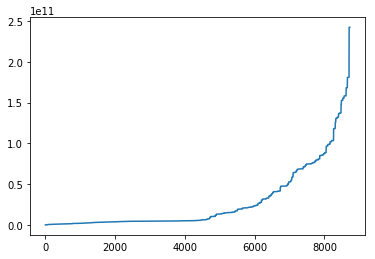

Вывод К ближайших соседей:


ValueError: too many values to unpack (expected 2)

In [60]:
simple_knn_clas_0 = simple_knn_clas.predict_for_single_object(K=5, \
                          prediction_type=PredictionType.CLASSIFICATION, \
                          X_o=data_test_0)
simple_knn_clas_0